## Loading Libs

In [146]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(55)

## Reading Data

In [2]:
df = pd.read_csv('ab_data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [4]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [5]:
df.groupby(['group','converted']).agg('count')

user_id  timestamp  landing_page
group     converted                                  
control   0           129479     129479        129479
          1            17723      17723         17723
treatment 0           129762     129762        129762
          1            17514      17514         17514

In [6]:
df.drop(df.query("group == 'control' and landing_page == 'new_page'").index, inplace=True)
df.drop(df.query("group == 'treatment' and landing_page == 'old_page'").index, inplace=True)

df.groupby(['group','converted']).agg('count')

user_id  timestamp  landing_page
group     converted                                  
control   0           127785     127785        127785
          1            17489      17489         17489
treatment 0           128047     128047        128047
          1            17264      17264         17264

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


## Cleaning Duplicated Users

In [8]:
df[df.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [9]:
df.drop_duplicates(['user_id'], inplace=True)

In [10]:
assert len(df['user_id'].unique()) == df['user_id'].size

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [12]:
df['converted'].mean()

0.11959708724499628

In [26]:
df.groupby(['group']).describe()

user_id                                                    \
              count           mean           std       min        25%   
group                                                                   
control    145274.0  788164.072594  91287.914601  630002.0  709279.50   
treatment  145310.0  787845.719290  91161.564429  630000.0  708745.75   

                                         converted                           \
                50%        75%       max     count      mean       std  min   
group                                                                         
control    788128.5  867208.25  945998.0  145274.0  0.120386  0.325414  0.0   
treatment  787876.0  866718.75  945999.0  145310.0  0.118808  0.323564  0.0   

                               
           25%  50%  75%  max  
group                          
control    0.0  0.0  0.0  1.0  
treatment  0.0  0.0  0.0  1.0

In [50]:
df.groupby(['group']).agg({'converted' : ['sum', 'count', 'mean']})

converted                  
                sum   count      mean
group                                
control       17489  145274  0.120386
treatment     17264  145310  0.118808

In [70]:
df[['group', 'converted']].groupby(['group']).agg('mean').T

group,control,treatment
converted,0.120386,0.118808


## Calculate Prob. of New and Old Pages Respectively

In [94]:
p_old_page = df[['group', 'converted']].query("group == 'control'")['converted'].mean()
p_new_page = df[['group', 'converted']].query("group == 'treatment'")['converted'].mean()
act_p_diff = p_new_page - p_old_page

print('p_old_page:\t{}\np_new_page:\t{}\np_diff:\t\t{}'.format(p_old_page, p_new_page, act_p_diff))

p_old_page:	0.1203863045004612
p_new_page:	0.11880806551510564
p_diff:		-0.0015782389853555567


## Calculate Counts of New and Old Pages Respectively

In [69]:
n_old =  len(df[['group']].query("group == 'control'"))
n_new =  len(df[['group']].query("group == 'treatment'"))

print('n_old:\t{}\nn_new:\t{}'.format(n_old, n_new))

n_old:	145274
n_new:	145310


## Simulating Randomly With Respect to Probs.

In [91]:
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_new_page, (1 - p_new_page)]).mean()
    old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_old_page, (1 - p_old_page)]).mean()
    diff = new_page_converted - old_page_converted
    p_diffs.append(diff)

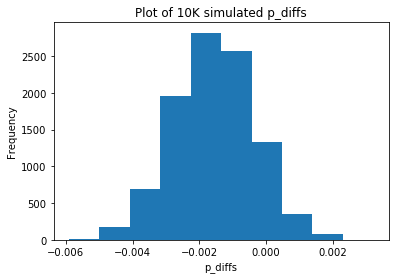

In [92]:
plt.hist(p_diffs)
plt.xlabel('p_diffs')
plt.ylabel('Frequency')
plt.title('Plot of 10K simulated p_diffs');

In [98]:
p_diffs = np.array(p_diffs)
(act_p_diff < p_diffs).mean()

0.5107

## Calculate Z critical score and p_value (area) Over Dataset

In [103]:
import statsmodels.api as sm

convert_old = sum(df.query("group == 'control'")['converted'])
convert_new = sum(df.query("group == 'treatment'")['converted'])

z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
print(z_score, p_value)

1.3109241984234394 0.9050583127590245


## Calculate Z score corresponding to Alpha (0.05)

In [104]:
from scipy.stats import norm

print(norm.cdf(z_score))
# Tells us how significant our z-score is

# for our single-sides test, assumed at 95% confidence level, we calculate: 
print(norm.ppf(1 - (0.05)))

0.9050583127590245
1.6448536269514722


## Calculate Power corresponding to Alpha (0.05), Effect Size

In [186]:
# sm.stats.zt_ind_solve_power(effect_size=-0.0048, alpha=0.05, power=0.1, alternative='smaller')
from statsmodels.stats import power as pwr
from statsmodels.stats.proportion import proportion_effectsize

es = proportion_effectsize(p_new_page, p_old_page)
ratio = (n_new / n_old)
pwr.NormalIndPower().power(es, n_old / ratio, alpha=0.05, ratio=ratio, alternative='smaller')

0.36915745621373575


<!-- https://www.isobudgets.com/introduction-statistics-uncertainty-analysis/ -->

## Confidence Interval (CI)
---
![](https://www.simplypsychology.org/confidence-interval.jpg?ezimgfmt=rs:553x332/rscb1/ng:webp/ngcb1)
## CI for z dist.
![](https://www.isobudgets.com/wp-content/uploads/2016/02/confidence-interval-known-standard-deviation.jpg)
## CI for t dist.
![](https://www.isobudgets.com/wp-content/uploads/2016/02/confidence-interval-unknown-standard-deviation.jpg)

## Sample vs Population
![](https://www.simplypsychology.org/sample.jpg?ezimgfmt=rs:553x346/rscb1/ng:webp/ngcb1)

## P-value on Normal Distribution
![](https://med.stanford.edu/news/all-news/2016/03/misleading-p-values-showing-up-more-often-in-journals/_jcr_content/main/image.img.476.high.jpg)

## Confusion Matrix for Hypothesis Testing
![](https://www.researchgate.net/profile/Dirk_Mallants/publication/307477421/figure/fig14/AS:614007576743980@1523402222972/Truth-table-used-in-hypothesis-testing.png)
![](https://images.squarespace-cdn.com/content/591e58f72994cab66b93f891/1495241679756-N45YXM495Q81FFSSE55I/Essoe-PowerAlpha9.png?content-type=image%2Fpng)

## z test score
![](https://www.researchgate.net/publication/297600508/figure/fig4/AS:670388308680713@1536844436654/Formula-for-the-Z-test_W640.jpg)

## t test score
![](https://www.isobudgets.com/wp-content/uploads/2016/02/t-score-equation-e1456854317764.jpg)


## z table (for alpha)
![](https://www.datavedas.com/wp-content/uploads/2017/12/1.1.2.1.2-Z-Scores-Z-Test-and-Probability-Distribution-1-K.jpg)
## t table (for alpha)
![](https://financetrain.com/assets/t-table.gif)

## Alpha (Type I Error), Beta (Type II Error) and Power
![](https://i2.wp.com/www.theanalysisfactor.com/wp-content/uploads/2009/12/one-sided-test.jpg?fit=579%2C423&ssl=1)
![](http://psychstat3.missouristate.edu/Documents/IntroBook3/images/errors05.gif)
![](https://www.researchgate.net/profile/Bruno_Ruettimann/publication/276166727/figure/fig3/AS:616389672972290@1523970158195/Relation-between-Alpha-and-Beta-risk-to-detect-an-effect-Delta.png)


## Two-tailed, Left-tailed, Right Tailed Hypothesis Testing
![](https://i.ytimg.com/vi/DlwOTOydeyk/maxresdefault.jpg)


## A/B Testing
![](https://receiptful-blog-staging.s3.amazonaws.com/2015/Apr/a_b_testing-1430250346717.jpg)
![](https://foxutech.com/wp-content/uploads/2018/10/AB-deployment.png)

## Two-sample z test for Difference Between Means
![](https://slideplayer.com/slide/3605887/13/images/11/Two+Sample+z-Test+for+the+Difference+Between+Means.jpg)
![](https://image.slideserve.com/910838/2-sample-z-test-known-variances-summary-n.jpg)
![](https://slideplayer.com/slide/7708373/25/images/17/Solution%3A+Two-Sample+z-Test+for+the+Difference+Between+Means.jpg)

## Example in Signal Detection with Diffrent Explanation
![](https://image.slidesharecdn.com/radar-2009-a6-detection-of-signals-in-noise-160213204027/95/radar-2009-a-6-detection-of-signals-in-noise-7-638.jpg?cb=1455396066)
## Hit, Miss, False Alarm, Correct Rejection and ROC Curve
![](https://i0.wp.com/www.frontiersin.org/files/Articles/147101/fpsyg-06-00762-HTML/image_m/fpsyg-06-00762-g001.jpg?w=584&ssl=1)
![](http://gru.stanford.edu/lib/exe/fetch.php/tutorials/neuraldprime.png?w=&h=&cache=cache)
![](https://www.cns.nyu.edu/~david/courses/perception/lecturenotes/sdt/ROC.gif)


<!-- https://www.statisticssolutions.com/statistical-analyses-effect-size/ -->

<!-- https://machinelearningmastery.com/statistical-power-and-power-analysis-in-python/ -->

<!-- https://machinelearningmastery.com/effect-size-measures-in-python/ -->